## Advanced Lane Finding Project

The goals / steps of this project are the following:

1. Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
1. Apply a distortion correction to raw images.
1. Use color transforms, gradients, etc., to create a thresholded binary image.
1. Apply a perspective transform to rectify binary image ("birds-eye view").
1. Detect lane pixels and fit to find the lane boundary.
1. Determine the curvature of the lane and vehicle position with respect to center.
1. Warp the detected lane boundaries back onto the original image.
1. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## 0. Import Libraries

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from numpy.linalg import inv

#%matplotlib qt

## 1. Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.

In [2]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
chess_images = glob.glob('./camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in chess_images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

'''
        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        cv2.imshow('img',img)
        cv2.waitKey(500)

cv2.destroyAllWindows()
'''

"\n        # Draw and display the corners\n        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)\n        cv2.imshow('img',img)\n        cv2.waitKey(500)\n\ncv2.destroyAllWindows()\n"

## 2. Apply a distortion correction to raw images.

In [3]:
def undistort(img, objpoints, imgpoints):
    
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[1:], None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    
    return undist

### Test for chessboard

True

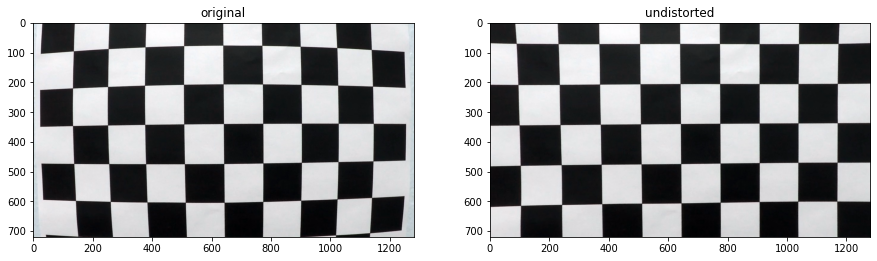

In [4]:
chessboard_image = cv2.imread('./camera_cal/calibration1.jpg')
save_directory = './output_images/undist_chessboard/'

plt.figure(figsize=(15,15))

undistorted = undistort(chessboard_image, objpoints, imgpoints)

# Parse file name
fname_split = fname.split('/')
img_name = fname_split[-1]

# Visualize
fig = plt.subplot(1,2,1)
plt.imshow(chessboard_image)
fig.set_title('original')

fig = plt.subplot(1,2,2)
plt.imshow(undistorted)
fig.set_title('undistorted')

# Save images
cv2.imwrite(save_directory + 'original.jpg', chessboard_image)
cv2.imwrite(save_directory + 'undistorted.jpg', undistorted)

### Test

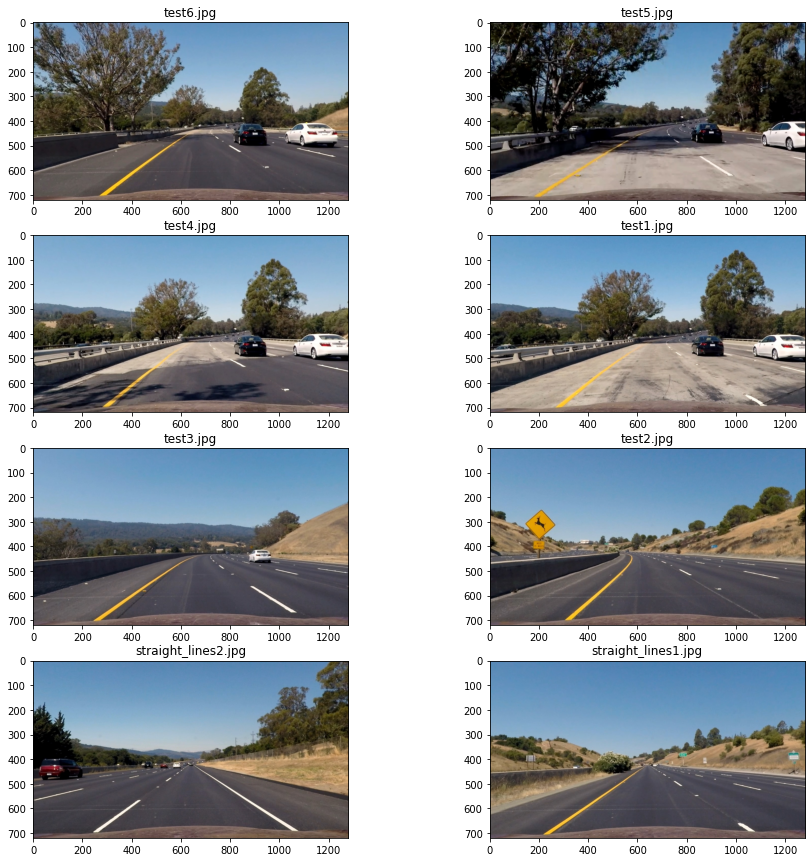

In [5]:
test_images = glob.glob('./test_images/*.jpg')
save_directory = './output_images/undist_images/'

plt.figure(figsize=(15,15))

for i, fname in enumerate(test_images):
    
    # Read test images
    img = cv2.imread(fname, 1)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    
    # 2. Apply a distortion correction to raw images.
    undistorted = undistort(img, objpoints, imgpoints)

    # Parse file name
    fname_split = fname.split('/')
    img_name = fname_split[-1]
    
    # Visualize
    fig = plt.subplot(4,2,i+1)
    plt.imshow(undistorted)
    fig.set_title(img_name)
    
    # Save images
    cv2.imwrite(save_directory + img_name, undistorted)

## 3. Use color transforms, gradients, etc., to create a thresholded binary image.

In [6]:
def create_binary_image(img):
    
    # Convert to HLS color space and separate the S channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    
    # Grayscale image
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    abs_sobelx = np.absolute(sobelx)
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    thresh_min = 20
    thresh_max = 100
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    
    # Threshold color channel
    s_thresh_min = 170
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1
    
    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1

    return combined_binary

### Test

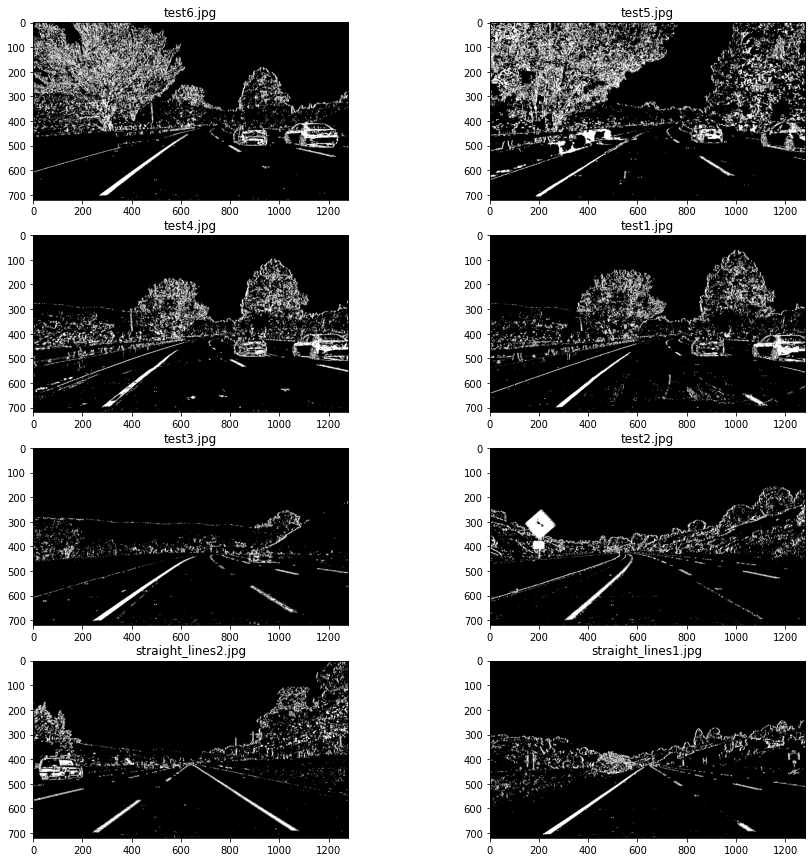

In [7]:
test_images = glob.glob('./test_images/*.jpg')
save_directory = './output_images/binary_images/'

plt.figure(figsize=(15,15))

for i, fname in enumerate(test_images):
    
    # Read test images
    img = cv2.imread(fname, 1)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    
    # 2. Apply a distortion correction to raw images.
    undistorted = undistort(img, objpoints, imgpoints)
    
    # 3. Use color transforms, gradients, etc., to create a thresholded binary image.
    binary_image = create_binary_image(undistorted)
    
    # Parse file name    
    fname_split = fname.split('/')
    img_name = fname_split[-1]
    
    # Visualize
    fig = plt.subplot(4,2,i+1)
    plt.imshow(binary_image, cmap="gray")
    fig.set_title(img_name)
    
    # Save images
    fname_split = fname.split('/')
    plt.imsave(save_directory + img_name, binary_image,cmap='gray')

## 4. Apply a perspective transform to rectify binary image ("birds-eye view").

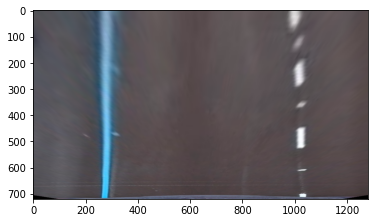

In [8]:
fname='./test_images/straight_lines1.jpg'
img = cv2.imread(fname, 1)

xsize = img.shape[1]  # 1280
ysize = img.shape[0]  # 720

s1 = [xsize // 2 - 66, 450]
s2 = [xsize // 2 + 66, 450]
s3 = [xsize, ysize]
s4 = [0, ysize]

src = np.float32([s1, s2, s3, s4])

d1 = [100, 0]
d2 = [xsize - 100, 0]
d3 = [xsize - 100, ysize]
d4 = [100, ysize]

dst = np.float32([d1, d2, d3, d4])


def warp(img, src, dst):
    
    xsize=img.shape[1]
    ysize=img.shape[0]
    img_size=(xsize,ysize)
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, img_size)
    
    return warped, M

undistorted = undistort(img, objpoints, imgpoints)
warped_image, M = warp(undistorted,src,dst)
plt.imshow(warped_image)

### Test

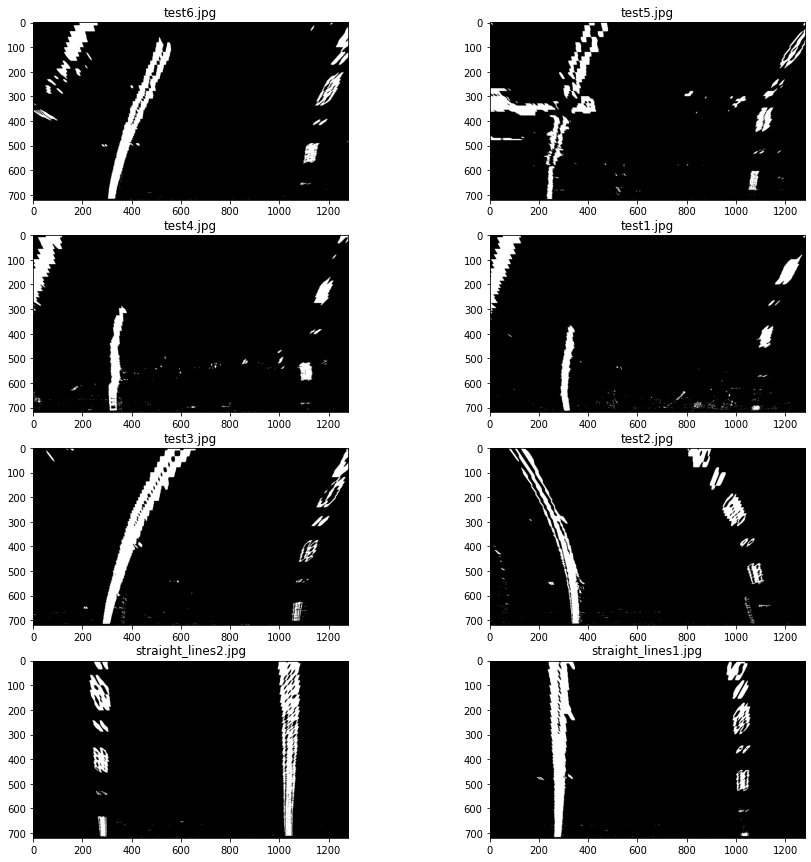

In [9]:
test_images = glob.glob('./test_images/*.jpg')
save_directory = './output_images/binary_warped_images/'

plt.figure(figsize=(15,15))
    
for i, fname in enumerate(test_images):
    
    # Read test images
    img = cv2.imread(fname, 1)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    
    # 2. Apply a distortion correction to raw images.
    undistorted = undistort(img, objpoints, imgpoints)
    
    # 3. Use color transforms, gradients, etc., to create a thresholded binary image.
    binary_image = create_binary_image(undistorted)
    
    # 4. Apply a perspective transform to rectify binary image ("birds-eye view").
    warped_image, M = warp(binary_image,src,dst)
    
    # Parse file name    
    fname_split = fname.split('/')
    img_name = fname_split[-1]
    
    # Visualize
    fig = plt.subplot(4,2,i+1)
    plt.imshow(warped_image, cmap="gray")
    fig.set_title(img_name)
    
    # Save images
    fname_split = fname.split('/')
    plt.imsave(save_directory + img_name, warped_image,cmap='gray')

## 5. Detect lane pixels and fit to find the lane boundary.

In [10]:
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty
        
    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    '''
    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    '''

    return out_img, left_fit_cr, right_fit_cr, left_fitx, right_fitx, ploty

## Test

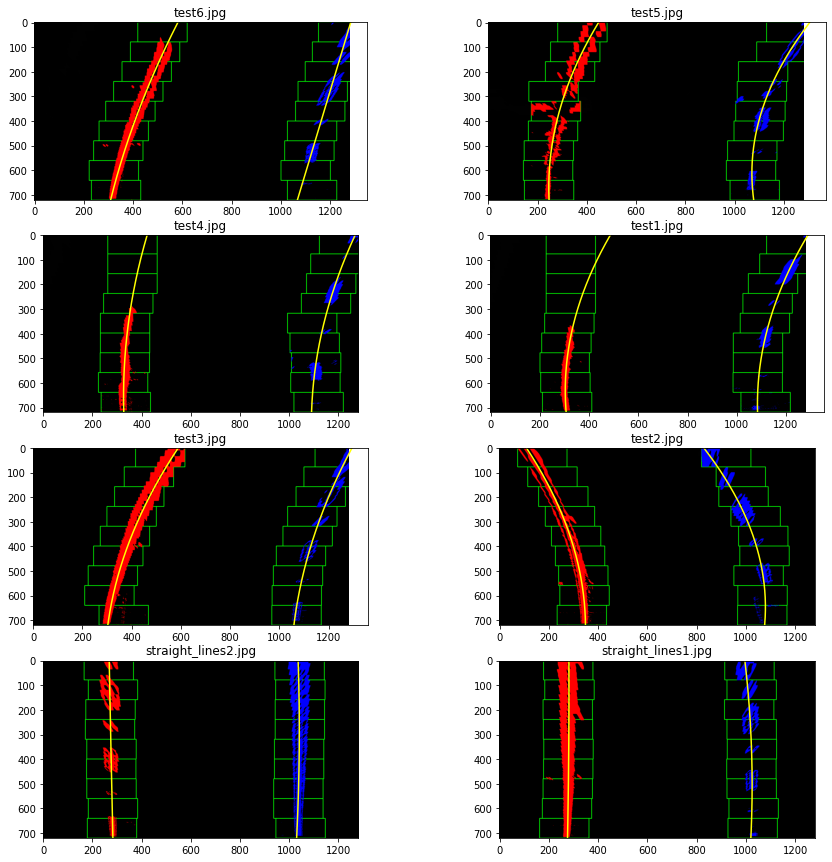

In [11]:
test_images = glob.glob('./test_images/*.jpg')
save_directory = './output_images/fit_images/'

plt.figure(figsize=(15,15))

for i, fname in enumerate(test_images):
    
    # Read test images
    img = cv2.imread(fname, 1)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    
    # 2. Apply a distortion correction to raw images.
    undistorted = undistort(img, objpoints, imgpoints)
    
    # 3. Use color transforms, gradients, etc., to create a thresholded binary image.
    binary_image = create_binary_image(undistorted)
    
    # 4. Apply a perspective transform to rectify binary image ("birds-eye view").
    warped_image, M = warp(binary_image,src,dst)
    
    #5. Detect lane pixels and fit to find the lane boundary.
    fit_img, left_fit_cr, right_fit_cr, left_fitx, right_fitx, ploty = fit_polynomial(warped_image)
    
    # Parse file name    
    fname_split = fname.split('/')
    img_name = fname_split[-1]
    
    # Visualize
    fig = plt.subplot(4,2,i+1)
    plt.imshow(fit_img)
    fig.set_title(img_name)
    
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    
    # Save images
    fname_split = fname.split('/')
    plt.imsave(save_directory + img_name, warped_image,cmap='gray')

## 6. Determine the curvature of the lane and vehicle position with respect to center.

In [12]:
def calculate_curvature(y_max, fit_cr):
    
    return ((1 + (2*fit_cr[0]*y_max*ym_per_pix + fit_cr[1])**2)**1.5) / np.absolute(2*fit_cr[0])

## Test

In [13]:
test_images = glob.glob('./test_images/*.jpg')

plt.figure(figsize=(15,15))

for i, fname in enumerate(test_images):
    
    # Read test images
    img = cv2.imread(fname, 1)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    
    # 2. Apply a distortion correction to raw images.
    undistorted = undistort(img, objpoints, imgpoints)
    
    # 3. Use color transforms, gradients, etc., to create a thresholded binary image.
    binary_image = create_binary_image(undistorted)
    
    # 4. Apply a perspective transform to rectify binary image ("birds-eye view").
    warped_image, M = warp(binary_image,src,dst)
    
    # 5. Detect lane pixels and fit to find the lane boundary.
    fit_img, left_fit_cr, right_fit_cr, left_fitx, right_fitx, ploty = fit_polynomial(warped_image)
    
    # 6. Determine the curvature of the lane and vehicle position with respect to center.
    left_curvature_km = calculate_curvature(719,left_fit_cr)/1000
    right_curvature_km = calculate_curvature(719,right_fit_cr)/1000
    print('{}:    Left: {:.2f} km, Right: {:.2f} km'.format(fname, left_curvature_km, right_curvature_km))

./test_images/test6.jpg:    Left: 0.91 km, Right: 116.36 km
./test_images/test5.jpg:    Left: 0.36 km, Right: 0.26 km
./test_images/test4.jpg:    Left: 0.73 km, Right: 0.55 km
./test_images/test1.jpg:    Left: 0.36 km, Right: 0.38 km
./test_images/test3.jpg:    Left: 0.45 km, Right: 0.58 km
./test_images/test2.jpg:    Left: 0.37 km, Right: 0.27 km
./test_images/straight_lines2.jpg:    Left: 61.12 km, Right: 2.83 km
./test_images/straight_lines1.jpg:    Left: 9.81 km, Right: 1.43 km


<Figure size 1080x1080 with 0 Axes>

## 7. Warp the detected lane boundaries back onto the original image.

In [14]:
def unwarp(img,Minv):
    img_size=(img.shape[1], img.shape[0])
    unwarped = warped = cv2.warpPerspective(img, Minv, img_size)
    return unwarped

def draw_lane(warped, undist, left_fitx, right_fitx, Minv):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (undist.shape[1], undist.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    
    return result

### Test

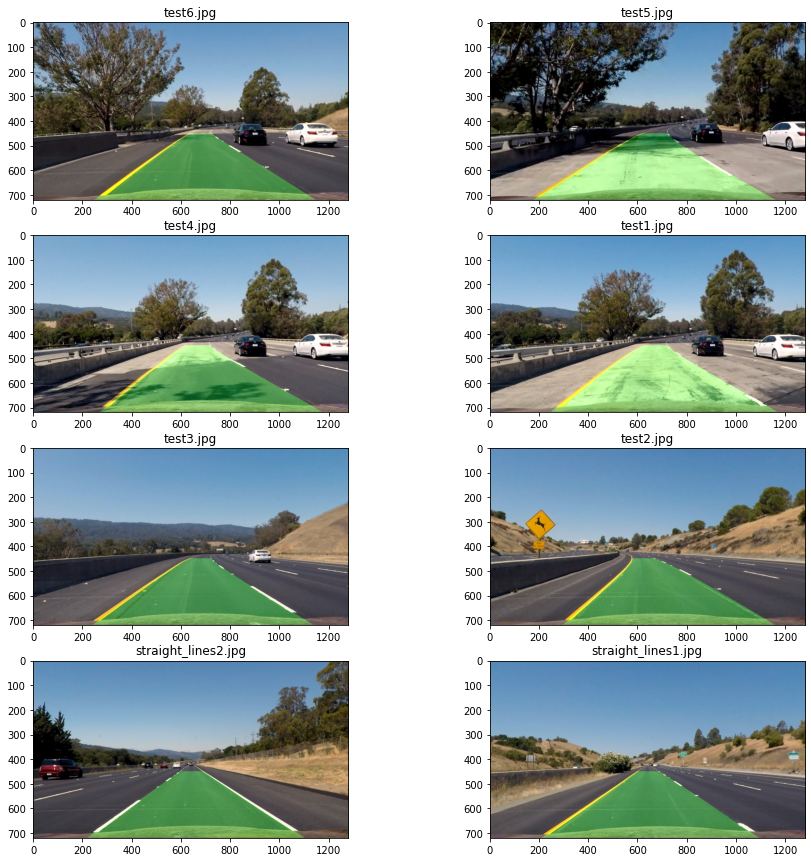

In [15]:
test_images = glob.glob('./test_images/*.jpg')
save_directory = './output_images/filled_images/'

plt.figure(figsize=(15,15))

for i, fname in enumerate(test_images):
    
    # Read test images
    img = cv2.imread(fname, 1)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    
    # 2. Apply a distortion correction to raw images.
    undistorted = undistort(img, objpoints, imgpoints)
    
    # 3. Use color transforms, gradients, etc., to create a thresholded binary image.
    binary_image = create_binary_image(undistorted)
    
    # 4. Apply a perspective transform to rectify binary image ("birds-eye view").
    warped_image, M = warp(binary_image,src,dst)
    
    # 5. Detect lane pixels and fit to find the lane boundary.
    fit_img, left_fit_cr, right_fit_cr, left_fitx, right_fitx, ploty = fit_polynomial(warped_image)
    
    # 6. Determine the curvature of the lane and vehicle position with respect to center.
    left_curvature_km = calculate_curvature(719,left_fit_cr)/1000
    right_curvature_km = calculate_curvature(719,right_fit_cr)/1000
    
    # 7. Warp the detected lane boundaries back onto the original image.
    Minv = inv(M)
    filled_image=draw_lane(warped_image,undistorted, left_fitx, right_fitx, Minv) 
    
    # Parse file name    
    fname_split = fname.split('/')
    img_name = fname_split[-1]
    
    # Visualize
    fig = plt.subplot(4,2,i+1)
    plt.imshow(filled_image)
    fig.set_title(img_name)
    
    # Save images
    fname_split = fname.split('/')
    plt.imsave(save_directory + img_name, filled_image)

## 8. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [16]:
def calculate_offset(img, left_pos, right_pos):
    
    ref_center = img.shape[1] / 2
    lines_mid = left_pos + (right_pos - left_pos) / 2
    
    return ref_center - lines_mid

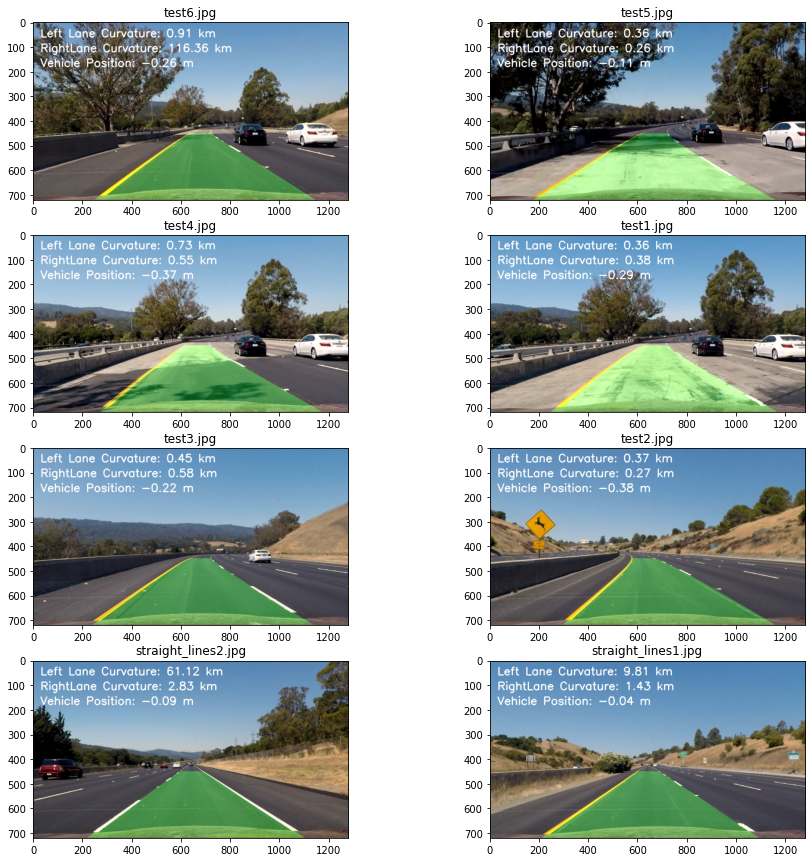

In [17]:
test_images = glob.glob('./test_images/*.jpg')
save_directory = './output_images/filled_images/'

plt.figure(figsize=(15,15))

for i, fname in enumerate(test_images):
    
    # Read test images
    img = cv2.imread(fname, 1)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    
    # 2. Apply a distortion correction to raw images.
    undistorted = undistort(img, objpoints, imgpoints)
    
    # 3. Use color transforms, gradients, etc., to create a thresholded binary image.
    binary_image = create_binary_image(undistorted)
    
    # 4. Apply a perspective transform to rectify binary image ("birds-eye view").
    warped_image, M = warp(binary_image,src,dst)
    
    # 5. Detect lane pixels and fit to find the lane boundary.
    fit_img, left_fit_cr, right_fit_cr, left_fitx, right_fitx, ploty = fit_polynomial(warped_image)
    
    # 6. Determine the curvature of the lane and vehicle position with respect to center.
    left_curvature_km = calculate_curvature(719,left_fit_cr)/1000
    right_curvature_km = calculate_curvature(719,right_fit_cr)/1000
    
    # 7. Warp the detected lane boundaries back onto the original image.
    Minv = inv(M)
    filled_image=draw_lane(warped_image,undistorted, left_fitx, right_fitx, Minv) 
    
    # 8. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.
    offset = calculate_offset(filled_image,left_fitx[-1],right_fitx[-1])*xm_per_pix
    left_curvature_text = "Left Lane Curvature: {:.2f} km".format(left_curvature_km)
    right_curvature_text = "RightLane Curvature: {:.2f} km".format(right_curvature_km)
    vehicle_pos_text = "Vehicle Position: {:.2f} {}".format(offset, "m")
    
    font_face = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 1.5
    font_color = (255,255,255)
    font_thickness = 4
    line_type = cv2.LINE_8
    
    cv2.putText(filled_image,left_curvature_text,(30,60),font_face,font_scale,font_color,font_thickness,line_type)
    cv2.putText(filled_image,right_curvature_text,(30,120),font_face,font_scale,font_color,font_thickness,line_type)
    cv2.putText(filled_image,vehicle_pos_text,(30,180),font_face,font_scale,font_color,font_thickness,line_type)
    
    # Parse file name    
    fname_split = fname.split('/')
    img_name = fname_split[-1]
    
    # Visualize
    fig = plt.subplot(4,2,i+1)
    plt.imshow(filled_image)
    fig.set_title(img_name)
    
    # Save images
    fname_split = fname.split('/')
    plt.imsave(save_directory + img_name, filled_image)

## Pipeline

In [18]:
# make sure to set objpoints and imgpoints as global variables for undistort function beforehand

def process_image(img):
    
    # 2. Apply a distortion correction to raw images.
    undistorted = undistort(img, objpoints, imgpoints)
    
    # 3. Use color transforms, gradients, etc., to create a thresholded binary image.
    binary_image = create_binary_image(undistorted)
    
    # 4. Apply a perspective transform to rectify binary image ("birds-eye view").
    warped_image, M = warp(binary_image,src,dst)
    
    # 5. Detect lane pixels and fit to find the lane boundary.
    fit_img, left_fit_cr, right_fit_cr, left_fitx, right_fitx, ploty = fit_polynomial(warped_image)
    
    # 6. Determine the curvature of the lane and vehicle position with respect to center.
    left_curvature_km = calculate_curvature(719,left_fit_cr)/1000
    right_curvature_km = calculate_curvature(719,right_fit_cr)/1000
    
    # 7. Warp the detected lane boundaries back onto the original image.
    Minv = inv(M)
    filled_image=draw_lane(warped_image,undistorted, left_fitx, right_fitx, Minv) 
    
    # 8. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.
    offset = calculate_offset(filled_image,left_fitx[-1],right_fitx[-1])*xm_per_pix
    left_curvature_text = "Left Lane Curvature: {:.2f} km".format(left_curvature_km)
    right_curvature_text = "RightLane Curvature: {:.2f} km".format(right_curvature_km)
    vehicle_pos_text = "Vehicle Position: {:.2f} {}".format(offset, "m")
    
    # Create and put overlay text
    font_face = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 1.5
    font_color = (255,255,255)
    font_thickness = 4
    line_type = cv2.LINE_8
    cv2.putText(filled_image,left_curvature_text,(30,60),font_face,font_scale,font_color,font_thickness,line_type)
    cv2.putText(filled_image,right_curvature_text,(30,120),font_face,font_scale,font_color,font_thickness,line_type)
    cv2.putText(filled_image,vehicle_pos_text,(30,180),font_face,font_scale,font_color,font_thickness,line_type)
    
    return filled_image

### Test

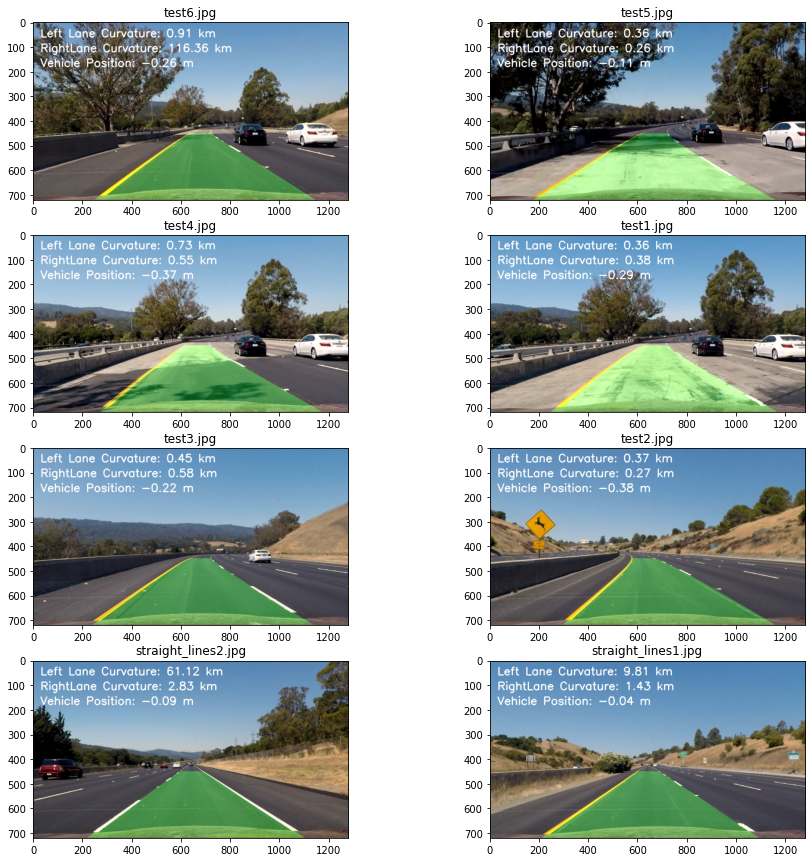

In [19]:
test_images = glob.glob('./test_images/*.jpg')

plt.figure(figsize=(15,15))

for i, fname in enumerate(test_images):
    
    # Read test images
    img = cv2.imread(fname, 1)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    
    # Process image
    result = process_image(img)
    
    # Parse file name    
    fname_split = fname.split('/')
    img_name = fname_split[-1]
    
    # Visualize
    fig = plt.subplot(4,2,i+1)
    plt.imshow(result)
    fig.set_title(img_name)

## Apply processing to project video

In [20]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

project_video_output = './output_videos/processed_project_video.mp4'

project_clip = VideoFileClip("./project_video.mp4")
processed_project_clip = project_clip.fl_image(process_image)

%time processed_project_clip.write_videofile(project_video_output, audio=False)

t:   0%|                             | 2/1260 [00:00<01:56, 10.80it/s, now=None]

Moviepy - Building video ./output_videos/processed_project_video.mp4.
Moviepy - Writing video ./output_videos/processed_project_video.mp4



Moviepy - Done !
Moviepy - video ready ./output_videos/processed_project_video.mp4
CPU times: user 9min 45s, sys: 1min 7s, total: 10min 52s
Wall time: 3min 39s


In [21]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_video_output))

## Apply processing to challenge video

In [22]:
challenge_video_output = './output_videos/processed_challenge_video.mp4'

challenge_video_clip = VideoFileClip("./challenge_video.mp4")
processed_challenge_clip = challenge_video_clip.fl_image(process_image)

%time processed_challenge_clip.write_videofile(challenge_video_output, audio=False)

t:   0%|                              | 2/485 [00:00<00:42, 11.42it/s, now=None]

Moviepy - Building video ./output_videos/processed_challenge_video.mp4.
Moviepy - Writing video ./output_videos/processed_challenge_video.mp4



Moviepy - Done !
Moviepy - video ready ./output_videos/processed_challenge_video.mp4
CPU times: user 3min 19s, sys: 26 s, total: 3min 45s
Wall time: 1min 19s


In [23]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_video_output))